# Age prediction females with informative region

Final jupyter notebook for age prediction using infrared spectrosocpy data from tsetse females with the informative region

## Changelog

### 2023-11-03

#### Modified

- Deleted non-used code
- Plots have been renamed


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import sys

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report


sys.path.append('../src')
from utilities import baseline_accuracy
from utilities import dataplotmelt
from utilities import test_model
from utilities import model_optimization
from utilities import variable_importance_df

In [3]:
colors = sn.color_palette("Set2") 

In [4]:
tsetse_data = pd.read_csv("../data/raw/TseTse_finaldatasetclean.csv")
tsetse_data.rename(columns={"Cat1":"Plate", "Cat3":"Sex", "Cat4":"Age", "Cat5":"Tissue"}, inplace=True)
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("T", 'Thorax')
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("H", 'Head')
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("A", 'Abdomen')

In [5]:
tsetse_data_copy = tsetse_data.copy()

In [6]:
tsetse_females_thorax = tsetse_data_copy.loc[(tsetse_data_copy['Sex'] == 'f') & (tsetse_data_copy['Tissue'] == 'Thorax')]

tsetse_females_head = tsetse_data_copy.loc[(tsetse_data_copy['Sex'] == 'f') & (tsetse_data_copy['Tissue'] == 'Head')]

In [7]:
tsetse_females_thorax.groupby("Age")["ID"].count()

Age
3d    136
5w     96
7w    122
Name: ID, dtype: int64

In [8]:
tsetse_females_head.groupby("Age")["ID"].count()

Age
3d    133
5w     92
7w    120
Name: ID, dtype: int64

In [9]:
tsetse_females_thorax_copy = tsetse_females_thorax.copy()
tsetse_females_head_copy = tsetse_females_head.copy()

## Age prediction females

In [36]:
X_thorax = tsetse_females_thorax.loc[:,"1750":"602"]
y_thorax = tsetse_females_thorax.loc[:,"Age"]

X_head = tsetse_females_head.loc[:,"1750":"602"]
y_head = tsetse_females_head.loc[:,"Age"]

In [37]:
waveNumslist_reduced = X_thorax.columns.values.tolist()
wavenumbers_reduced = [int(x) for x in waveNumslist_reduced]

In [38]:
X_th_train, X_th_test, y_th_train, y_th_test = train_test_split(X_thorax, y_thorax, test_size=0.2, shuffle=True, random_state=123)

X_hd_train, X_hd_test, y_hd_train, y_hd_test = train_test_split(X_head, y_head, test_size=0.2, shuffle=True, random_state=123)

In [39]:
females_thorax_acc_baseline = baseline_accuracy(X_th_train, y_th_train)
females_head_acc_baseline = baseline_accuracy(X_hd_train,y_hd_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [40]:
data_plot_thorax = dataplotmelt(females_thorax_acc_baseline)
data_plot_head = dataplotmelt(females_head_acc_baseline)

In [42]:
output = data_plot_head.groupby(['param_clf'], as_index=False).agg({'value':['mean','std']})
print(output)

  param_clf     value          
                 mean       std
0      CART  0.708929  0.042132
1        LR  0.844643  0.032657
2        RF  0.794643  0.053406
3       SVC  0.773214  0.065232


In [43]:
output = data_plot_thorax.groupby(['param_clf'], as_index=False).agg({'value':['mean','std']})
print(output)

  param_clf     value          
                 mean       std
0      CART  0.684211  0.054859
1        LR  0.847368  0.047545
2        RF  0.749123  0.063012
3       SVC  0.736842  0.057298


In [44]:
# model optimization

# Head
best_model_head = model_optimization(X_hd_train,y_hd_train)

Best model parameters{'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'liblinear'}


In [45]:
# thorax
best_mdoel_thorax = model_optimization(X_th_train, y_th_train)

Best model parameters{'model__C': 100, 'model__penalty': 'l2', 'model__solver': 'liblinear'}


In [46]:
# test head

y_head_pred, y_head_prob, pipe_head = test_model(X_hd_train, X_hd_test, y_hd_train, best_model_head)
y_thorax_pred, y_thorax_prob, pipe_thorax = test_model(X_th_train, X_th_test, y_th_train, best_mdoel_thorax)

In [47]:
accuracy_head = accuracy_score(y_hd_test, y_head_pred)
accuracy_thorax = accuracy_score(y_th_test, y_thorax_pred)
print(f"Accuracy on test set: {accuracy_head}")
print(f"Accuracy on test set: {accuracy_thorax}")

Accuracy on test set: 0.8260869565217391
Accuracy on test set: 0.8732394366197183


In [21]:
report_head = classification_report(y_hd_test, y_head_pred, output_dict=True)
report_head = pd.DataFrame(report_head).transpose()
report_head["Tissue"] = "Head"

In [28]:
report_head.to_excel("../results/tables/informative_region_results/accuracy_age_females_head.xlsx")

In [22]:
report_thorax = classification_report(y_th_test, y_thorax_pred, output_dict=True)
report_thorax = pd.DataFrame(report_thorax).transpose()
report_thorax["Tissue"] = "Thorax"

In [23]:
report_age_females_informative = pd.concat([report_head,report_thorax])
report_age_females_informative.to_excel("../results/tables/informative_region_results/accuracy_age_females_info.xlsx")

In [48]:
# top wavenumbers

topwavenumbers = variable_importance_df(wavenumbers_reduced,best_mdoel_thorax)
topwavenumbers

,Wavenumbers,Coefficients
332,1086,4.347480
487,776,4.316641
333,1084,4.307320
152,1446,4.291869
151,1448,4.043973
153,1444,3.945151
534,682,3.866186
404,942,3.863673
533,684,3.798696
92,1566,3.760028


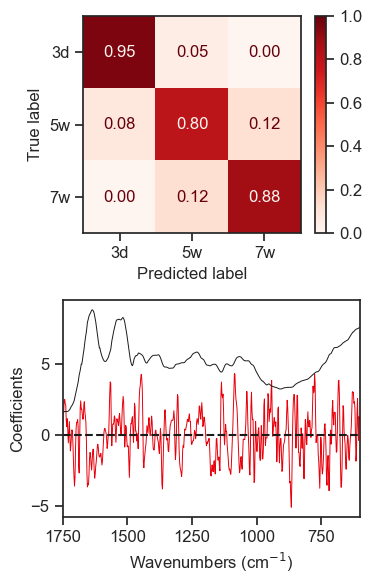

In [50]:
# final plot
# coefficients and confusion matrix for thorax

rc={'font.size': 12,
    "font.family":"Arial",
    "axes.labelsize":12,
    'xtick.labelsize':12,
    'ytick.labelsize':12}

sn.set_style("ticks")
sn.set_context('notebook', rc=rc)
sn.set_palette('bright', color_codes=True)


fig, (ax, ax2) = plt.subplots(2,1, figsize=(4,6), tight_layout=True)

disp = ConfusionMatrixDisplay.from_predictions(y_th_test,y_thorax_pred,display_labels=pipe_thorax.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax, im_kw={'vmin':0, 'vmax':1})


sn.lineplot(x=wavenumbers_reduced, y=best_mdoel_thorax['model'].coef_[0],ax=ax2, color='r', linewidth=0.7)
sn.lineplot(x=wavenumbers_reduced, y=(np.mean(X_thorax ,axis=0)*30), ax=ax2, color='k', linewidth=0.7)

ax2.set_xlim(1750,600)
ax2.axhline(0, ls='--', color='k')
ax2.set_xlabel("Wavenumbers (cm$^{-1}$)")
ax2.set_ylabel("Coefficients")


#for i in range(0, 20):
 #   ax2.axvline(topwavenumbers.iloc[i,0], color='r', alpha=0.5)

plt.savefig("../results/plots/Fig5_age_females_head_informative.tiff", dpi=300)

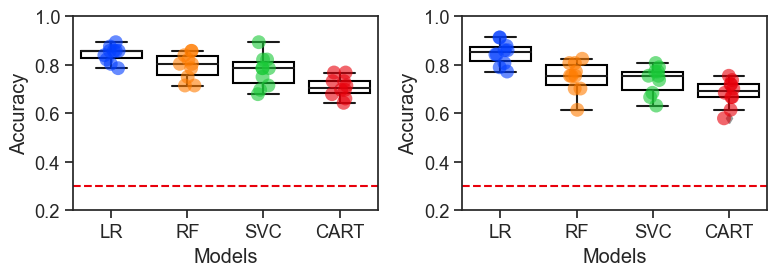

In [51]:
# training plots
# confucion matrix for the head

sn.set(font_scale=1.2)
sn.set_style("ticks")
sn.set_palette('bright', color_codes=True)

fig, ((ax,ax3)) = plt.subplots(1,2, figsize=(8,3), tight_layout=True)

sn.boxplot(data=data_plot_thorax, x='param_clf', y='value',ax=ax3, color='white')
sn.stripplot(data=data_plot_thorax, x='param_clf',y='value', ax=ax3,
            size = 10,
           alpha = 0.6,            
           hue='param_clf',
            legend=False)
plt.setp(ax3.lines, color='k')
ax3.axhline(0.3, color='r',ls='--')
ax3.set_ylim(0.2,1)
ax3.set_xlabel("Models")
ax3.set_ylabel("Accuracy")
for i,box in enumerate(ax3.patches):
    box.set_edgecolor('black')

sn.boxplot(data=data_plot_head, x='param_clf', y='value',ax=ax, color='white')
sn.stripplot(data=data_plot_head, x='param_clf',y='value', ax=ax,
            size = 10,
           alpha = 0.6,            
           hue='param_clf',
            legend=False)
plt.setp(ax.lines, color='k')
ax.axhline(0.3, color='r',ls='--')
ax.set_ylim(0.2,1)
ax.set_xlabel("Models")
ax.set_ylabel("Accuracy")
for i,box in enumerate(ax.patches):
    box.set_edgecolor('black')

plt.savefig("../results/plots/females_age_training_informative_suplementary.tiff", dpi=300)


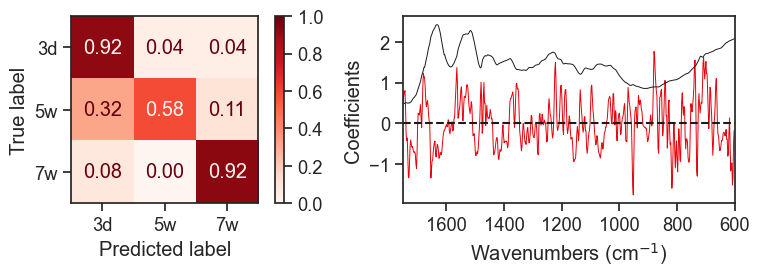

In [55]:
sn.set(font_scale=1.2)
sn.set_style("ticks")
sn.set_palette('bright', color_codes=True)

fig, (ax, ax2) = plt.subplots(1,2, figsize=(8,3), tight_layout=True)

disp = ConfusionMatrixDisplay.from_predictions(y_hd_test,y_head_pred,display_labels=pipe_head.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax, im_kw={'vmin':0, 'vmax':1})


sn.lineplot(x=wavenumbers_reduced, y=best_model_head['model'].coef_[0],ax=ax2, color='r', linewidth=0.7)
sn.lineplot(x=wavenumbers_reduced, y=(np.mean(X_head ,axis=0)*8), ax=ax2, color='k', linewidth=0.7)

ax2.set_xlim(1750,600)
ax2.axhline(0, ls='--', color='k')
ax2.set_xlabel("Wavenumbers (cm$^{-1}$)")
ax2.set_ylabel("Coefficients")


plt.savefig("../results/plots/age_females_head_informative_suplementary.tiff", dpi=300)
